## package 

In [2]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from numpy import random

from matplotlib import pyplot as plt
import sys
import time
from sklearn.preprocessing import OneHotEncoder
import math
from sklearn.preprocessing import StandardScaler
import original_data
# import optuna
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader

## params

In [3]:
# ITER_PATH = './Datasets/{train_or_test}_iter_{temperature}.pth'
PATH = './He_forecast/model_{model}/'
LOSS_PATH = PATH + 'loss_{temperature}.txt'
RESULT_PATH = PATH + 'result_{temperature}.txt'
MODEL_PATH = PATH + '{model}_{temperature}_{epoch}.pkl'
LOG_PATH = 'output/{date}_{information}.txt'
LOG_FIGURE_PATH = 'output/{date}_{information}.png'

TEMPERATURE = 400
LEARNING_RATE = 1e-5
TRY_TIMES = 10
TEMPERATURE = 400
MAX = 1.0
MIN = 0.5
TIME_LENGTH = 50
STRIDE = 5
STEADY_LENGTH = 100
MIGRATION_LENGTH = 50
EMBEDDING_SIZE = 12
N_TRIAL = 100
INPUT_SIZE = 15
BATCH_SIZE = 1024
EPOCHS = 1000

# DEVICE = torch.device('mps' if torch.cuda.is_available() else 'cpu')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## data process

In [19]:
PATH = './data/timedt.data.400'

def get_original_data(
   path:str
):
    """
    input temperature : 温度
    
    return t, msd, csp, xyz, r_, v_xyz, v_, angle, g

    t       时间序列(单位:ps)
    msd     单He的msd(均方位移)
    csp     CSP(中心对称参数)
    xyz     单He的xyz坐标
    r_      单He离原点距离
    v_xyz   单He的沿xyz坐标的速度分量
    v_      单He的速度大小
    """
    with open(path, 'r', encoding='utf-8') as fin:
        t = []      # 时间序列(单位:ps)
        msd = []    # 单He的msd(均方位移)
        csp = []    # CSP(中心对称参数)
        xyz = []    # 单He的xyz坐标
        r_ = []     # 单He离原点距离
        v_xyz = []  # 单He的沿xyz坐标的速度分量
        v_ = []     # 单He的速度大小
        for i, line in enumerate(fin.readlines()[1:]):
            data = list(map(float, line.strip().split(' ')))
            t.append(data[0])
            msd.append(data[1])
            csp.append(data[2:8])
            xyz.append(data[8:11])
            r_.append(data[11])
            v_xyz.append(data[12:15])
            v_.append(data[15])

    # with open(G_PATH.format(Temperature=temperature), 'r', encoding='utf-8') as fin:
    #     g = []      # g参数
    #     for i, line in enumerate(fin.readlines()[1:]):
    #         data = list(map(float, line.strip().split(' ')))
    #         g.append(data[1:7])
    # indices_to_remove = np.arange(1001, len(t) - 1, 1001)
    t = np.array(t)
    # t = np.delete(t, indices_to_remove)
    t = t.reshape(-1, 1)
    msd = np.array(msd)
    # msd = np.delete(msd, indices_to_remove)
    msd = msd.reshape(-1, 1)
    csp = np.array(csp)
    # csp = np.delete(csp, indices_to_remove, axis=0)
    xyz = np.array(xyz)
    # xyz = np.delete(xyz, indices_to_remove, axis=0)
    r_ = np.sqrt(np.array(r_))
    # r_ = np.delete(r_, indices_to_remove)
    r_ = r_.reshape(-1, 1)
    v_xyz = np.array(v_xyz)
    # v_xyz = np.delete(v_xyz, indices_to_remove, axis=0)
    v_ = np.sqrt(np.array(v_))
    # v_ = np.delete(v_, indices_to_remove)
    v_ = v_.reshape(-1, 1)
    angle = np.arccos(v_xyz / v_.reshape(len(t), 1))
    # g = np.array(g)

    return t, msd, csp, xyz, r_, v_xyz, v_, angle# , g

In [49]:
def get_iter():
    train_iter = torch.load(ITER_PATH.format(train_or_test='train', temperature=TEMPERATURE))   
    test_iter = torch.laoad(ITER_PATH.format(train_or_test='test', temperature=TEMPERATURE))
    return train_iter, test_iter


def get_train_iter(
    Temperature, 
    Batch_size, 
):
    y = np.load('MigFaceLabel_400_16.npy')
    index = (y[:,0]+y[:,1])//2
    # label = original_data.get_migration_label(Temperature)
    # index = np.where(label[TIME_LENGTH//2 : -TIME_LENGTH//2])[0] + TIME_LENGTH//2
    data_num = len(index)

    print(index)
    print(data_num)

    t, msd, csp, xyz, r_, v_xyz, v_, angle = original_data.get_original_data(Temperature)
    sample_size = len(t)
    
    data = np.hstack((
        # msd.reshape((sample_size, 1)), 
        csp, 
        xyz, 
        # r_.reshape((sample_size, 1)), 
        v_xyz, 
        # v_.reshape((sample_size, 1)), 
        angle, 
        # g
    ))
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data_X = torch.from_numpy(data)
    # print(data_X.shape)
    # data_Y = torch.from_numpy(csp[:,5])
    y = y[:,2].reshape(-1,1)
    encoder = OneHotEncoder(sparse=False)
    one_hot = encoder.fit_transform(y)
    data_Y = torch.from_numpy(one_hot)
    # r_ = torch.from_numpy(r_)
    # mean_r = torch.mean(r_)
    # std_r = torch.std(r_)
    # data_Y = torch.normal(mean=mean_r, std=std_r, size=r_.size())
    X = torch.zeros(data_num, TIME_LENGTH, INPUT_SIZE)
    Y = torch.zeros(data_num, 4)
    
    # i=0
    #     # for i, idx in enumerate(sample_indices):
    # for idx in range(TIME_LENGTH//2, data_X.shape[0]-TIME_LENGTH//2, TIME_LENGTH):
    #     X[i, :, :] = data_X[idx-TIME_LENGTH//2 : idx+TIME_LENGTH//2]
    #     Y[i]       = data_Y[idx]
    #     i+=1
    for i in range(data_num):
        X[i, :, :] = data_X[index[i]-TIME_LENGTH//2 : index[i]+TIME_LENGTH//2]
        Y[i, :]       = data_Y[i]

    X = X.float().unsqueeze(1) # [Batch_size, C, H, W]
    Y = Y.float() # [Batch_size, H_out]

    shuffled_index = np.random.permutation(range(data_num))
    X = X[shuffled_index]
    Y = Y[shuffled_index]
    Train_X, Test_X = X[:int(data_num*0.8)], X[int(data_num*0.8):]
    Train_Y, Test_Y = Y[:int(data_num*0.8)], Y[int(data_num*0.8):]

    Train_generator = DataLoader(
        torch.utils.data.TensorDataset(Train_X, Train_Y), 
        Batch_size, 
        shuffle=True
    )
    Test_generator = DataLoader(
        torch.utils.data.TensorDataset(Test_X, Test_Y), 
        Batch_size, 
        shuffle=True
    )
    return Train_generator, Test_generator



## 网络

### CNN网络

In [50]:
class CNN(nn.Module):
    def __init__(
        self, 
        Channel_in, 
        Height_in, 
        Width_in, 
        Output_size, 
        Filter_num, 
        Kernel_list, 
        dropout = 0.5, 
    ):
        super(CNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    Channel_in, 
                    Filter_num, 
                    kernel_size=(kernel, Width_in), 
                    padding=((kernel - 1) // 2, 0), 
                ),
                nn.ReLU(),
                nn.MaxPool2d(
                    kernel_size=((Height_in+3)//4, 1), 
                    stride=(Height_in+3)//4, 
                    padding=((Height_in-Height_in//4*4+1)//2, 0), 
                ), 
            )
            for kernel in Kernel_list
        ])
        self.fc = nn.Sequential(
            nn.Dropout(dropout), 
            nn.Linear(Filter_num * len(Kernel_list) * 4, 64),
            nn.ReLU(), 
            nn.Linear(64, 16), 
            nn.Linear(16, Output_size)
        )

    def forward(self, x):
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out



## train

### train and evaluation 

In [51]:
def train(
    net:nn.Module, 
    Train_generator, 
    loss_func,
    optimizer, 
    scheduler, 
    device
):
    net = net.to(device)
    net.train()
    sum_loss = []
    
    Train_generator =  DataLoader(Train_generator.dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    for x, y in Train_generator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        scores = net(x)
        loss = loss_func(scores, y)
        sum_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    return np.array(sum_loss).mean()
    
def evaluate(
    net:nn.Module, 
    Test_generator, 
    loss_func,
    optimizer, 
    scheduler, 
    device
):
    sum_loss = []
    net.eval()
    Test_generator = DataLoader(Test_generator.dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
    for x, y in Test_generator:
        x = x.to(device)
        y = y.to(device)
        scores = net(x)
        loss = loss_func(scores, y)
        sum_loss.append(loss.item())
    
    return np.array(sum_loss).mean()

### train multi epochs

In [52]:
def train_multi_epochs(
    net:nn.Module, 
    Train_generator, 
    Test_generator,     
    loss_func,
    optimizer, 
    scheduler, 
    epochs, 
    device, 
    information:str, 
    show_train_process=None
):
    best_epoch = 0
    best_test_loss = 9.9e9
    best_net = net.state_dict()
    sum_train_loss, sum_test_loss = [], []
    date0 = time.strftime('%Y-%m-%d %a %H-%M-%S', time.localtime(time.time()))

    with open(LOG_PATH.format(date=date0, information=information), 'w') as log_fin:
        log_fin.write(information + '\n')
        log_fin.write('epoch' + ' ' + 'train_loss' + ' ' + 'test_loss' + ' ' + 'time' + ' ' + 'best_epoch' + '\n')
        t1 = time.time()
        for epoch in range(epochs):
            t0 = time.time()
            train_loss = train(net, Train_generator, loss_func, optimizer, scheduler, device).item()
            test_loss = evaluate(net, Test_generator, loss_func, optimizer, scheduler, device).item()

            sum_train_loss.append(train_loss)
            sum_test_loss.append(test_loss)

            if epoch == 0 or test_loss < best_test_loss:
                best_epoch = epoch
                best_test_loss = test_loss
                best_net = net.state_dict()

            log_fin.write(str(epoch) + ' ' + str(train_loss) + ' ' + str(test_loss) + ' ' + str(time.time()-t0) + ' ' + str(best_epoch) + '\n')
            if show_train_process != None and epoch % show_train_process == 0:
                print('epoch={:>4}, train_loss= {:.4f}, test_loss= {:.4f}, time= {:.2f}sec, best_epoch= {:>4}'.format(epoch, train_loss, test_loss, time.time()-t1, best_epoch))
                t1 = time.time()
        
        log_fin.write('\n')
        log_fin.write('best_epoch=' + str(best_epoch) + '\n')
        log_fin.write('best_test_loss=' + str(best_test_loss) + '\n')
    return best_test_loss, best_epoch, best_net, sum_train_loss, sum_test_loss


### singal train CNN

In [54]:
def singal_train_CNN(lr=LEARNING_RATE, ga=0.5, dropout=0.5):
    t1 = time.time()
    train_iter, test_iter = get_train_iter(TEMPERATURE, BATCH_SIZE)
    criteon = nn.CrossEntropyLoss().to(DEVICE)
    net = CNN(1, TIME_LENGTH, INPUT_SIZE, 4, 32, [9, 7, 5, 3], dropout)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0)
    scheduler = MultiStepLR(optimizer, [int(EPOCHS*0.2), int(EPOCHS*0.4)], ga, last_epoch=-1)

    best_test_loss, best_epoch, best_net, multi_train_loss, multi_test_loss = train_multi_epochs(net, train_iter, test_iter, criteon, optimizer, scheduler, EPOCHS, DEVICE, 'Temperature={}'.format(TEMPERATURE), show_train_process=10)
    torch.save(best_net, f'./He_forecast/best_model_{t1}.pth')
    print('best_test_loss= {:.4f}, best_epoch= {:>4}, time= {:.2f}sec'.format(best_test_loss, best_epoch, time.time()-t1))

    plt.plot(multi_train_loss)
    plt.plot(multi_test_loss)
    plt.show()
    
    return best_test_loss

[   490    540    611 ... 999382 999464 999536]
6581


/root/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


epoch=   0, train_loss= 1.2922, test_loss= 1.2979, time= 0.08sec, best_epoch=    0
epoch=  10, train_loss= 1.2611, test_loss= 1.2599, time= 0.71sec, best_epoch=   10
epoch=  20, train_loss= 1.2220, test_loss= 1.2195, time= 0.59sec, best_epoch=   20
epoch=  30, train_loss= 1.1828, test_loss= 1.1929, time= 0.71sec, best_epoch=   28
epoch=  40, train_loss= 1.1627, test_loss= 1.1529, time= 0.69sec, best_epoch=   40
epoch=  50, train_loss= 1.1482, test_loss= 1.1366, time= 0.60sec, best_epoch=   50
epoch=  60, train_loss= 1.1417, test_loss= 1.1430, time= 0.71sec, best_epoch=   56
epoch=  70, train_loss= 1.1200, test_loss= 1.1087, time= 0.60sec, best_epoch=   70
epoch=  80, train_loss= 1.1275, test_loss= 1.1164, time= 0.69sec, best_epoch=   76
epoch=  90, train_loss= 1.1129, test_loss= 1.0991, time= 0.71sec, best_epoch=   81
epoch= 100, train_loss= 1.1208, test_loss= 1.1177, time= 0.60sec, best_epoch=   95
epoch= 110, train_loss= 1.1055, test_loss= 1.0744, time= 0.69sec, best_epoch=  110
epoc

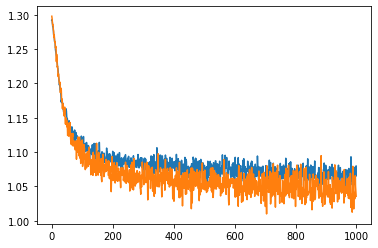

1.0098358988761902

In [55]:
singal_train_CNN()

In [21]:
model = CNN(1, TIME_LENGTH, INPUT_SIZE, 1, 32, [9, 7, 5, 3], 0.5)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 43233


In [1]:
import numpy as np
from collections import defaultdict
y = np.load('MigFaceLabel_400_16.npy')
labels = y[:,2]
states = list(set(labels))
n = len(states)
state_index = {state: i for i, state in enumerate(states)}

transition_matrix = np.zeros((n, n))

for (current_state, next_state) in zip(labels[:-1], labels[1:]):
    transition_matrix[state_index[current_state]][state_index[next_state]] += 1
transition_prob_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

print("转移矩阵（概率形式）:")
print(transition_prob_matrix)


转移矩阵（概率形式）:
[[0.26983051 0.55186441 0.08067797 0.09762712]
 [0.2121134  0.59742268 0.09201031 0.09845361]
 [0.18041237 0.63230241 0.104811   0.08247423]
 [0.23017107 0.59253499 0.06998445 0.10730949]]


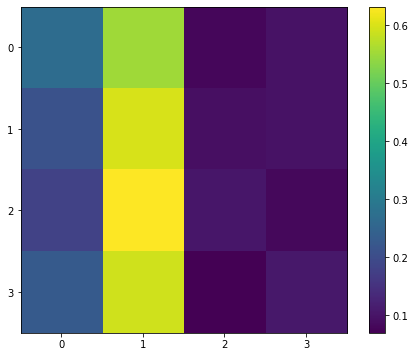

In [17]:
plt.figure(figsize=(8, 6))
plt.imshow(transition_prob_matrix, cmap='viridis')  # 使用'viridis'颜色图
plt.colorbar()  # 显示颜色条
plt.xticks(np.arange(transition_prob_matrix.shape[1]), range(transition_prob_matrix.shape[1]))  # 设置x轴标签
plt.yticks(np.arange(transition_prob_matrix.shape[0]), range(transition_prob_matrix.shape[0]))  # 设置y轴标签
plt.show()

# 用一些机器学习方法写的

In [20]:
y = np.load('MigFaceLabel_400_16.npy')
index = y[:,0]
# label = original_data.get_migration_label(Temperature)
# index = np.where(label[TIME_LENGTH//2 : -TIME_LENGTH//2])[0] + TIME_LENGTH//2
data_num = len(index)

print(index)
print(data_num)

t, msd, csp, xyz, r_, v_xyz, v_, angle = get_original_data(PATH)
sample_size = len(t)

data = np.hstack((
    # msd.reshape((sample_size, 1)), 
    csp, 
    xyz, 
    # r_.reshape((sample_size, 1)), 
    v_xyz, 
    # v_.reshape((sample_size, 1)), 
    angle, 
    # g
))
scaler = StandardScaler()
data = scaler.fit_transform(data)
data_X = torch.from_numpy(data)
# print(data_X.shape)
# data_Y = torch.from_numpy(csp[:,5])
y = y[:,2].reshape(-1,1)
encoder = OneHotEncoder(sparse=False)
one_hot = encoder.fit_transform(y)
data_Y = torch.from_numpy(one_hot)
# r_ = torch.from_numpy(r_)
# mean_r = torch.mean(r_)
# std_r = torch.std(r_)
# data_Y = torch.normal(mean=mean_r, std=std_r, size=r_.size())

    


[   464    516    565 ... 999349 999415 999514]
6581


/root/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [78]:
X = torch.zeros(data_num-1, TIME_LENGTH, INPUT_SIZE)
Y = torch.zeros(data_num-1, 4)

for i in range(data_num-1):
    X[i, :, :] = data_X[index[i]-TIME_LENGTH//2 : index[i]+TIME_LENGTH//2]
    Y[i, :]       = data_Y[i+1]

X = X.float() # [Batch_size, C, H, W]
Y = Y.float() # [Batch_size, H_out]

shuffled_index = np.random.permutation(range(data_num-1))
X = X[shuffled_index]
X = X.reshape(data_num-1, -1)
# X = torch.cat((X, data_Y[:-1]), dim=-1)
X = data_Y[:-1]
Y = Y[shuffled_index]
Train_X, Test_X = X[:int(data_num*0.8)], X[int(data_num*0.8):]
Train_Y, Test_Y = Y[:int(data_num*0.8)], Y[int(data_num*0.8):]

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import numpy as np


In [81]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [82]:
rf_model.fit(Train_X, Train_Y)

RandomForestClassifier(random_state=42)

In [83]:
predictions = rf_model.predict(Test_X)

In [94]:
len(rf_model.predict_proba(Test_X))

4

In [84]:
from sklearn.metrics import f1_score
f1_test = f1_score(Test_Y, predictions, average='weighted')
f1_train = f1_score(Train_Y, rf_model.predict(Train_X), average='weighted')
print(f'F1 test Score: {f1_test:.4f}')
print(f'F1 train Score: {f1_train:.4f}')

F1 test Score: 0.4265
F1 train Score: 0.4404


In [85]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(Test_Y, predictions, average='weighted')  # 或者 'weighted'
recall = recall_score(Test_Y, predictions, average='weighted')  # 或者 'weighted'
print(f'precision Score: {precision:.4f}')
print(f'recall Score: {recall:.4f}')

precision Score: 0.3370
recall Score: 0.5805


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


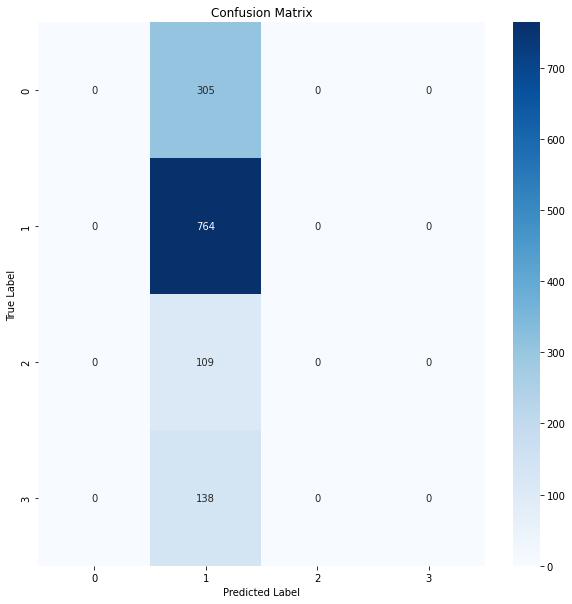

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels_true = np.argmax(Test_Y, axis=1)
labels_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(labels_true, labels_pred)

# 使用 Seaborn 绘制混淆矩阵的热图
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 显示图形
plt.show()

In [88]:
predictions

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [95]:
pip install sklearn-crfsuite

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 1.1 MB 2.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
from sklearn_crfsuite import CRF, metrics

crf = CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)

# 训练CRF模型
crf.fit(Train_X, Train_Y)

# 预测测试数据
y_pred = crf.predict(Test_X)

# 评估模型性能
print(metrics.flat_classification_report(Test_Y, y_pred))

SystemError: <method 'dim' of 'torch._C._TensorBase' objects> returned a result with an error set

In [97]:
Train_X.shape

torch.Size([5264, 4])

In [98]:
Train_Y.shape

torch.Size([5264, 4])